# About competition

If you have two sentences, there are three ways they could be related: one could entail the other, one could contradict the other, or they could be unrelated. Natural Language Inferencing (NLI) is a popular NLP problem that involves determining how pairs of sentences (consisting of a premise and a hypothesis) are related.

The task is to create an NLI model that assigns labels of 0, 1, or 2 (corresponding to entailment, neutral, and contradiction) to pairs of premises and hypotheses. To make things more interesting, the train and test set include text in fifteen different languages.

For more information on the problem, you can visit [Contradictory, My Dear Watson competition](https://www.kaggle.com/c/contradictory-my-dear-watson/overview)

# 1. Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from keras import backend as k
from keras.utils import to_categorical

!pip install transformers sentencepiece
import transformers
from transformers import BertTokenizer, TFBertModel
import sentencepiece
import re

# 2. Data Overview and EDA (Exploration Data Analysis)

The training set contains a premise, a hypothesis, a label (0 = entailment, 1 = neutral, 2 = contradiction), and the language of the text. For more information about what these mean and how the data is structured, check out the data page: https://www.kaggle.com/c/contradictory-my-dear-watson/data

## 2.1 Data Load

Let's load the data with the read_csv from Pandas.

In [ ]:
train = pd.read_csv('/train.csv')
test = pd.read_csv('/test.csv')

## 2.2 Data Overview

Let's take a quick look on the training set.

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12120 entries, 0 to 12119
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          12120 non-null  object
 1   premise     12120 non-null  object
 2   hypothesis  12120 non-null  object
 3   lang_abv    12120 non-null  object
 4   language    12120 non-null  object
 5   label       12120 non-null  int64 
dtypes: int64(1), object(5)
memory usage: 568.2+ KB


Let's check the pairs of contradicting sentences.

In [ ]:
print(train[train['label'] == 2]['premise'])

1        These are issues that we wrestle with in pract...
7                    From Cockpit Country to St. Ann's Bay
13             我希望你的领主能够最终开始认识到，向这样的人授予国王委员会的愚蠢行为反对我的所有建议。
14       म्जोडी का दावा है कि वह शादी करने के लिए मोरक्...
19       The streets are crammed with vendors selling s...
                               ...                        
12104    Да, - сказал Огле, - это правда. Но были и те,...
12110    Well, we've just got to get down to it, that's...
12115    The results of even the most well designed epi...
12117    The important thing is to realize that it's wa...
12118    At the west end is a detailed model of the who...
Name: premise, Length: 4064, dtype: object


For example, 12104 sentence is in Russian language.

In [ ]:
print(train['premise'][12104])
print(train['hypothesis'][12104])

Да, - сказал Огле, - это правда. Но были и те, кто по-прежнему открыто и откровенно выступали против этого курса.
Огл никогда не упоминал противников существующего курса.


There is a clear contradiction between these sentences.

Let's look at the distribution of languages in the training set.

In [ ]:
num_lang = train.groupby('language')['id'].count().sort_values(ascending=False).reset_index()
num_lang = pd.DataFrame(num_lang)
num_lang['count'] = num_lang['id']
num_lang = num_lang.drop('id',axis=1)
num_lang_data = num_lang.style.background_gradient(cmap='Greens')
num_lang_data

,language,count
0,English,6870
1,Chinese,411
2,Arabic,401
3,French,390
4,Swahili,385
5,Urdu,381
6,Vietnamese,379
7,Russian,376
8,Hindi,374
9,Greek,372


In [ ]:
test_num_lang = test.groupby('language')['id'].count().sort_values(ascending=False).reset_index()
test_num_lang = pd.DataFrame(test_num_lang)
test_num_lang['count'] = test_num_lang['id']
test_num_lang = test_num_lang.drop('id',axis=1)
test_num_lang_data = test_num_lang.style.background_gradient(cmap='Oranges')
test_num_lang_data

,language,count
0,English,2945
1,Spanish,175
2,Swahili,172
3,Russian,172
4,Urdu,168
5,Greek,168
6,Turkish,167
7,Thai,164
8,Arabic,159
9,French,157


## 2.3 Data Visualization

In [ ]:
fig = px.pie(num_lang,values='count',names='language',title='Language and their percentage in the train data :',color_discrete_sequence=px.colors.sequential.GnBu)
fig.update_traces(hoverinfo='label+percent', textfont_size=14,
                  marker=dict(line=dict(color='#000000', width=1.2)))
fig.show()

fig = px.pie(test_num_lang,values='count',names='language',title='Language and their percentage in the test data :',color_discrete_sequence=px.colors.sequential.RdBu)
fig.update_traces(hoverinfo='label+percent', textfont_size=14,
                  marker=dict(line=dict(color='#000000', width=1.2)))
fig.show()

It is obvious that English pairs of sentences are dominating. It is also good that data in the test and training sets is splitted equally.

Let's check if the dataset has NA spots.

In [ ]:
print(train.isna().sum())
print(test.isna().sum())

id            0
premise       0
hypothesis    0
lang_abv      0
language      0
label         0
dtype: int64
id            0
premise       0
hypothesis    0
lang_abv      0
language      0
dtype: int64


The data is not missing any of the information.
Let's check the distribution between labels.

In [ ]:
num_labels = train.groupby('label')['id'].count().sort_values(ascending=False).reset_index()
num_labels = pd.DataFrame(num_labels)
num_labels['count'] = num_labels['id']
num_labels = num_labels.drop('id',axis=1)
num_labels_data = num_labels.style.background_gradient(cmap='Reds')
num_labels_data

,label,count
0,0,4176
1,2,4064
2,1,3880


In [ ]:
fig = px.pie(num_labels,values='count',names='label',title='Labels and their percentage in the train data :',color_discrete_sequence=px.colors.sequential.RdBu)
fig.update_traces(hoverinfo='label+percent', textfont_size=14,
                  marker=dict(line=dict(color='#000000', width=1.2)))
fig.show()

It is obvious that the labels are splitted more or less equally.

## 2.4 Text Processing Visualization

There is not much we can draw from regular data so let's jump into texts processing.

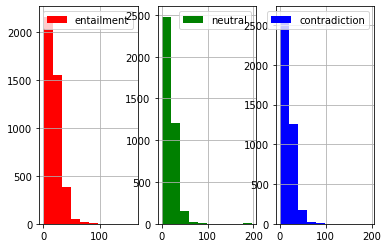

In [ ]:
train['premise_len'] = train['premise'].apply(lambda x: len(x.split(' ')))
train['hypothesis_len'] = train['hypothesis'].apply(lambda x: len(x.split(' ')))

fig, ax = plt.subplots(1, 3)
train[train.label==0].premise_len.hist(ax=ax[0], color='red', label='entailment', bins=10)
ax[0].legend();
train[train.label==1].premise_len.hist(ax=ax[1], color='green', label='neutral', bins=10)
ax[1].legend();
train[train.label==2].premise_len.hist(ax=ax[2], color='blue', label='contradiction', bins=10)
ax[2].legend();

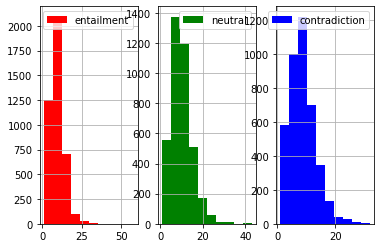

In [ ]:
fig, ax = plt.subplots(1, 3)
train[train.label==0].hypothesis_len.hist(ax=ax[0], color='red', label='entailment', bins=10)
ax[0].legend();
train[train.label==1].hypothesis_len.hist(ax=ax[1], color='green', label='neutral', bins=10)
ax[1].legend();
train[train.label==2].hypothesis_len.hist(ax=ax[2], color='blue', label='contradiction', bins=10)
ax[2].legend();

It seems that hypothesis have much wider distribution despite having less words in the sentence on average. Still these are not really good metrics when dealing with several languages as some languages are more verbose than the others.

# Building an XLM-RoBERTa model

Natural Language Inference (NLI) is a specific type of NLP task where we must determine whether or not a hypothesis is true based on a premise. The current leading model in this field is RoBERTa. 
                     
RoBERTa, introduced at Facebook, robustly optimized BERT approach. RoBERTa is a retraining of BERT with improved training methodology, 1000% more data and compute power.
                      
To improve the training procedure, RoBERTa removes the Next Sentence Prediction (NSP) task from BERT’s pre-training and introduces dynamic masking so that the masked token changes during the training epochs. Larger batch-training sizes were also found to be more useful in the training procedure. It is also trained on a big amount of different languages so it is considered multilingual which is an advantage because we don't need to translate all of the sentences that aren't in English.

## TPU Configuration

In [ ]:
DEVICE = 'TPU'

In [ ]:
if DEVICE == 'TPU':
    print('Connecting to TPU...')
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU :',tpu.master())
    except ValueError:
        print('Could not connect to TPU')
        tpu = None
        
    if tpu:
        try:
            print('Initializing TPU...')
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu)
            strategy = tf.distribute.experimental.TPUStrategy(tpu)
            print('TPU initialized!')
            
        except _:
            print('Failed to initialized TPU')
            
    else:
        DEVICE='GPU'

if DEVICE != 'TPU':
    print('Using default strategy for CPU and single GPU')
    strategy = tf.distribute.get_strategy()

if DEVICE == 'GPU':
    print('Num GPUs available : ',len(tf.config.experimental.list_physical_devices('GPU')))
    
AUTO = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print('REPLICAS : ',REPLICAS)

Connecting to TPU...
Running on TPU : grpc://10.9.19.226:8470
Initializing TPU...


INFO:tensorflow:Initializing the TPU system: grpc://10.9.19.226:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.9.19.226:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


TPU initialized!
REPLICAS :  8


In [ ]:
Batch_size = 16 * strategy.num_replicas_in_sync
epochs = 13
AUTO = tf.data.experimental.AUTOTUNE

MODEL = 'jplu/tf-xlm-roberta-large'

## Data modeling

In [ ]:
target = train['label']
train = train.drop('label',axis=1)
train_text = [None] * len(train)
test_text = [None] * len(test)
for i in range(len(train)):
    train_text[i] = train['premise'][i] + ' ' + train['hypothesis'][i]
for i in range(len(test)):
    test_text[i] = test['premise'][i] + ' ' + test['hypothesis'][i]

In [ ]:
tokenizer = transformers.AutoTokenizer.from_pretrained(MODEL)

In [ ]:
def roberta_encode(texts, maxlen=512):
    enc_di = tokenizer.batch_encode_plus(
        texts,  
        pad_to_max_length=True,
        max_length=maxlen
    )
    
    return np.array(enc_di['input_ids'])

In [ ]:
train_input_ids = roberta_encode(train_text,maxlen=100)
test_input_ids = roberta_encode(test_text,maxlen=100)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning:

The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).



## Train-Test Split

In [ ]:
from sklearn.model_selection import train_test_split
train_input_ids,validation_input_ids,train_labels,validation_labels = train_test_split(train_input_ids,target,test_size=0.2)

ValueError: ignored

In [ ]:
train_input_ids[7]

array([     0,  35919,  71056,   8974,  52195,     13,     72, 230726,
            7,      9,    165,  82781,  48798,   3471,      5,   1004,
        10264,    269,   1918,  32664,      5,      2,      1,      1,
            1,      1,      1,      1,      1,      1,      1,      1,
            1,      1,      1,      1,      1,      1,      1,      1,
            1,      1,      1,      1,      1,      1,      1,      1,
            1,      1,      1,      1,      1,      1,      1,      1,
            1,      1,      1,      1,      1,      1,      1,      1,
            1,      1,      1,      1,      1,      1,      1,      1,
            1,      1,      1,      1,      1,      1,      1,      1,
            1,      1,      1,      1,      1,      1,      1,      1,
            1,      1,      1,      1,      1,      1,      1,      1,
            1,      1,      1,      1])

In [ ]:
validation_input_ids[1]

array([     0,  35575,     77,   5063, 101695,  99488,   3280,   4135,
        30943,  15137,    637,  14271,  94274, 167857,  19933,     77,
          114,  54337,    888,     61, 204145,  14927,      5,      2,
            1,      1,      1,      1,      1,      1,      1,      1,
            1,      1,      1,      1,      1,      1,      1,      1,
            1,      1,      1,      1,      1,      1,      1,      1,
            1,      1,      1,      1,      1,      1,      1,      1,
            1,      1,      1,      1,      1,      1,      1,      1,
            1,      1,      1,      1,      1,      1,      1,      1,
            1,      1,      1,      1,      1,      1,      1,      1,
            1,      1,      1,      1,      1,      1,      1,      1,
            1,      1,      1,      1,      1,      1,      1,      1,
            1,      1,      1,      1])

In [ ]:
test_input_ids[3]

array([     0,      6,   1189,   7048, 133619,  57915,   1102,  43007,
         9085,   6959,    887,  27770,     43,  21443,   3344,   3327,
        97567,   1230,  25133,      6,  27770,   1189,   5610,   9085,
         5693,      4,   4673,  33841,   1198,  98450,  52611,  18635,
           30,      2,      1,      1,      1,      1,      1,      1,
            1,      1,      1,      1,      1,      1,      1,      1,
            1,      1,      1,      1,      1,      1,      1,      1,
            1,      1,      1,      1,      1,      1,      1,      1,
            1,      1,      1,      1,      1,      1,      1,      1,
            1,      1,      1,      1,      1,      1,      1,      1,
            1,      1,      1,      1,      1,      1,      1,      1,
            1,      1,      1,      1,      1,      1,      1,      1,
            1,      1,      1,      1])

In [ ]:
validation_labels

7722     0
718      0
10127    0
4400     0
7334     0
        ..
2112     0
1533     0
4041     2
5908     1
6451     0
Name: label, Length: 2424, dtype: int64

In [ ]:
train_labels

6897     1
5357     1
734      0
1433     1
5940     1
        ..
458      0
11659    0
8276     1
3040     0
4003     2
Name: label, Length: 9696, dtype: int64

In [ ]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((train_input_ids,train_labels))
    .repeat()
    .shuffle(2048)
    .batch(Batch_size)
    .prefetch(AUTO)
)

validation_dataset = (
    tf.data.Dataset
    .from_tensor_slices((validation_input_ids, validation_labels))
    .batch(Batch_size)
    .cache()
    .prefetch(AUTO)
)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(test_input_ids)
    .batch(Batch_size)
)

## XLM-RoBERTa Model

In [ ]:
def create_model(bert_model):
    input_ids = tf.keras.Input(shape=(100,),dtype='int32')
  
    output = bert_model(input_ids)[0]
    output = output[:,0,:]
    output = tf.keras.layers.Dense(3,activation='softmax')(output)
    model = tf.keras.models.Model(inputs = input_ids,outputs = output)
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
    bert_model = (
        
        transformers.TFAutoModel  
        .from_pretrained(MODEL)    
    )
    model = create_model(bert_model)  

Some layers from the model checkpoint at jplu/tf-xlm-roberta-large were not used when initializing TFXLMRobertaModel: ['lm_head']
- This IS expected if you are initializing TFXLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFXLMRobertaModel were initialized from the model checkpoint at jplu/tf-xlm-roberta-large.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaModel for predictions without further training.


In [ ]:
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
tfxlm_roberta_model (TFXLMRo TFBaseModelOutputWithPool 559890432 
_________________________________________________________________
tf.__operators__.getitem_4 ( (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 3075      
Total params: 559,893,507
Trainable params: 559,893,507
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(train_dataset,
                    validation_data = validation_dataset,
                    epochs = epochs,   
                    batch_size = Batch_size,
                    steps_per_epoch = len(train_input_ids)//Batch_size
                   )

Epoch 1/13


75/75 [==============================] - ETA: 0s - loss: 1.3925 - accuracy: 0.3397 WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


75/75 [==============================] - 1693s 22s/step - loss: 1.3909 - accuracy: 0.3397 - val_loss: 1.1192 - val_accuracy: 0.3436
Epoch 2/13
55/75 [=====================>........] - ETA: 6:50 - loss: 1.1585 - accuracy: 0.3662

KeyboardInterrupt: ignored

In [ ]:
pred = model.predict(test_dataset,verbose=1)
print(len(pred))
pred = pred.argmax(axis=1)
submission.prediction = pred      
submission.to_csv('submission.csv',index=False)    
submission.head()

# BERT

In [ ]:
model_name = 'bert-base-multilingual-cased'
tokenizer = BertTokenizer.from_pretrained(model_name)

In [ ]:
def encode_sentence(s):
    tokens = list(tokenizer.tokenize(s))
    tokens.append('[SEP]')
    return tokenizer.convert_tokens_to_ids(tokens)

In [ ]:
premise = train['premise'].values
hypothesis = train['hypothesis'].values

In [ ]:
premise = [re.sub('\d+', '0', s) for s in premise]       #Set all numbers to 0
premise = [s.lower() for s in premise]                   #English should be all lowercase
hypothesis = [re.sub('\d+', '0', s) for s in hypothesis] #Set all numbers to 0
hypothesis = [s.lower() for s in hypothesis]             #English should be all lowercase

In [ ]:
def bert_encode(hypotheses, premises, tokenizer):
    
    num_examples = len(hypotheses)

    sentence1 = tf.ragged.constant([encode_sentence(s) for s in np.array(hypotheses)])
    sentence2 = tf.ragged.constant([encode_sentence(s) for s in np.array(premises)])

    cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])] * sentence1.shape[0]
    input_word_ids = tf.concat([cls, sentence1, sentence2], axis=-1)

    input_mask = tf.ones_like(input_word_ids).to_tensor()

    type_cls = tf.zeros_like(cls)
    type_s1 = tf.zeros_like(sentence1)
    type_s2 = tf.ones_like(sentence2)
    input_type_ids = tf.concat([type_cls, type_s1, type_s2], axis=-1).to_tensor()

    inputs = {
        'input_word_ids': input_word_ids.to_tensor(),
        'input_mask': input_mask,
        'input_type_ids': input_type_ids}

    return inputs

In [ ]:
train_input = bert_encode(train.premise.values, train.hypothesis.values, tokenizer)

In [ ]:
MAX_LEN = 259
def build_model():
    bert_encoder = TFBertModel.from_pretrained(model_name)
    input_word_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_word_ids')
    input_mask = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_mask')
    input_type_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_type_ids')
    
    embedding = bert_encoder([input_word_ids, input_mask, input_type_ids])[0]

    x = embedding
    
    x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.Conv1D(32, 3)(x)
    
    x = x[:,0,:]
    
    output = tf.keras.layers.Dense(3, activation='softmax')(x)
    
    model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=output)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(lr=1e-5),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])
    
    return model

In [ ]:
with strategy.scope():
    model = build_model()
    model.summary()

In [ ]:
history = model.fit(train_input,
                    train.label.values,
                    epochs=13,
                    verbose=1,
                    batch_size=64,
                    validation_split=0.2)